# Testing the model
In this notebook we will simulate SCR data of the reversal task
- Start with only phase 1 (before reversal)
- Test pymc3 model on the simulated data
- If works well $\rightarrow$ continue to phase 2

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan

import pymc3 as pm
import arviz as az
importn_subjtsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
scr = pd.read_csv('firstSCRpart.csv')
#scr_two = pd.read_csv('se')
scr['sub'].unique()
scrTwo = scr[(scr['sub']==30)]

In [3]:
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
  
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    else:
        shockVec[i] = 0
        if cond=='CSminus1':
            stimVec[i] = 0
        else:
            stimVec[i] = 1
# increase trial number
print(shockVec.shape)
print(stimVec.shape)
shockVec[27] = 1 # add another

(30,)
(30,)
(30,)


In [4]:
print(stimVec)
print(shockVec[:])

[1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0]
[1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0]


In [5]:
shockVec = np.hstack([shockVec] *1)
stimVec = np.hstack([stimVec] * 1)

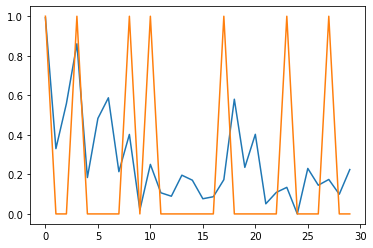

In [6]:
plt.plot(scrVec)
#plt.plot(stimVec)
plt.plot(shockVec)

# Simulate SCR based on stimulus and shock

## do it to subjects and run model

In [7]:
def simulateSCR(alpha, stimVec, shockVec, intercept, slope):
    scrSim = np.zeros(len(stimVec))
    scrCSp = 0.5
    scrCSm = 0.5
    # set intercept and slopes
    for i,(s,t) in enumerate(zip(stimVec,shockVec)):
        # print(i)
        # print(f'Stim is {s}')
        # print(f'Shock is{t}')
        if s==1:      
            pe = t - scrCSp   # prediction error
            scrCSp = scrCSp + alpha*pe
            scrSim[i] = scrCSp
        if s==0:
            pe = t - scrCSm   # prediction error
            scrCSm = scrCSm + alpha*pe
            scrSim[i] = scrCSm
        # add intercept and slope
        scrSim[i] = scrSim[i] + np.random.normal(0,.1) # add noise #
        
        scrSim[i] =  slope*scrSim[i]
        
    return scrSim

In [8]:
# generate 10 subjects with different alphas
n_subj = 10 # number of subjects
alphalist = []
interceptList = []
slopeList = []

subjects = np.empty([shockVec.shape[0],n_subj]) # create an empty matrix of trials X subjects
for i in np.arange(n_subj):
   # print(i)
    alpha = np.random.beta(a=1,b=1)
    intercept = np.random.normal(0,1)
    slope = np.random.normal(0,1)
    subjects[:,i] = simulateSCR(alpha, stimVec, shockVec, intercept, slope)
    alphalist.append(alpha)
    interceptList.append(intercept)
    slopeList.append(slope)

In [ ]:
subjects.shape

# Test logp with MLE

In [9]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    stim, shock, scr  = args
    
    scrSim = np.zeros(len(stim))
    scrCSp = 0.5
    scrCSm = 0.5
    # set intercept and slopes
    for i,(s,t) in enumerate(zip(stim,shock)):
       
        if s==1:      
            pe = t - scrCSp   # prediction error
            scrCSp = scrCSp + alpha*pe
            scrSim[i] = scrCSp
        if s==0:
            pe = t - scrCSm   # prediction error
            scrCSm = scrCSm + alpha*pe
            scrSim[i] = scrCSm
        # add intercept and slope
        scrSim[i] = scrSim[i] 
        
        scrSim[i] =  beta*scrSim[i]
   
    scrPred = scrSim
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(scipy.stats.norm.logpdf(scr, scrPred))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 
    

In [10]:
logSub = []
estLog = []
for i in np.arange(n_subj):
    x0 = [alphalist[i], slopeList[i]]
    estLog.append(scipy.optimize.minimize(llik_td, x0, args=(stimVec,shockVec , subjects[:,i]), method='L-BFGS-B'))
    print(estLog[i].x)

[ 0.79822986 -0.33271889]
[ 0.66744936 -1.45219295]
[0.64421757 0.40373949]
[ 0.05625863 -0.74120759]
[0.07103946 0.59139927]
[ 0.32404807 -0.65034563]
[ 0.13912691 -1.46790815]
[ 0.84340441 -1.63192903]
[ 0.59427852 -0.38197911]
[ 0.34318776 -0.04747848]


In [11]:
alphalist

[0.8928877893034539,
 0.6210780971322087,
 0.6383316086564161,
 0.07323156882205992,
 0.038476693618789824,
 0.26981999008054647,
 0.15444770169353894,
 0.9063246992312924,
 0.6337869702026921,
 0.34442128265592353]

In [ ]:
slopeList

# Test the PyMC code

In [12]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = shock - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
    
   
    return Qs, vec

In [13]:
#subIDX = np.array(subIDX).flatten()
n_subj = subjects.shape[1]
n_trials=stimVec.shape[0]

In [14]:
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)


In [15]:
# organize the vectors to feed
stim =np.reshape([stimVec]*n_subj, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape([shockVec]*n_subj, (n_subj,n_trials)).T


In [16]:
n_subj

10

In [17]:
# turn to tensores
stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)

In [18]:
# test the function first
results, vec = theano_llik_td(alphalist,stim, shock, n_subj)

In [19]:
vec.eval().shape

(30, 10, 1)

# Now Comparing Different Models
- Now we can test which of the models recovers the known $\alpha$ from the data

In [20]:
# try alpha as beta distribution
with pm.Model() as mB:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    trB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


In [22]:
az.summary(trB, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.789,0.097,0.617,0.969,0.002,0.001,3364.0,1888.0,1.0
alpha[1],0.668,0.024,0.623,0.711,0.000,0.000,3705.0,3014.0,1.0
alpha[2],0.642,0.093,0.471,0.825,0.002,0.001,3742.0,2237.0,1.0
alpha[3],0.058,0.015,0.031,0.089,0.000,0.000,3892.0,2246.0,1.0
alpha[4],0.074,0.024,0.031,0.119,0.000,0.000,2559.0,1464.0,1.0
alpha[5],0.330,0.052,0.240,0.428,0.001,0.001,5207.0,2934.0,1.0
alpha[6],0.140,0.013,0.116,0.164,0.000,0.000,4534.0,3316.0,1.0
alpha[7],0.844,0.021,0.804,0.881,0.000,0.000,2971.0,2481.0,1.0
alpha[8],0.595,0.101,0.394,0.774,0.002,0.001,3890.0,2460.0,1.0
alpha[9],0.484,0.269,0.001,0.916,0.004,0.003,5041.0,2403.0,1.0


In [23]:
#slopeList
alphalist

[0.8928877893034539,
 0.6210780971322087,
 0.6383316086564161,
 0.07323156882205992,
 0.038476693618789824,
 0.26981999008054647,
 0.15444770169353894,
 0.9063246992312924,
 0.6337869702026921,
 0.34442128265592353]

In [ ]:
az.plot_trace(trB)

## Recovering ok but not perfect
- When using 60 trials - recover is much better
- Lets add hierarchy to see how helpful this can be

In [24]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    #betaHyper= pm.Normal('betaH', 0, 1)
    alpha_h = pm.Beta('alpha_h', 1,1)
    alpha_sigma = pm.HalfNormal('alpha_sigma', .1)
    alpha = pm.Normal('alpha', alpha_h , alpha_sigma, shape=n_subj)
    
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    
    tr_h = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, alpha, alpha_sigma, alpha_h]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
az.summary(tr_h, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.738,0.095,0.563,0.926,0.002,0.001,3913.0,2981.0,1.0
alpha[1],0.666,0.024,0.622,0.710,0.000,0.000,4712.0,3307.0,1.0
alpha[2],0.616,0.088,0.452,0.784,0.001,0.001,4114.0,3236.0,1.0
alpha[3],0.059,0.016,0.030,0.089,0.000,0.000,3290.0,2795.0,1.0
alpha[4],0.078,0.023,0.033,0.121,0.000,0.000,3086.0,2557.0,1.0
alpha[5],0.334,0.050,0.240,0.422,0.001,0.001,4914.0,3195.0,1.0
alpha[6],0.140,0.013,0.116,0.164,0.000,0.000,4701.0,2942.0,1.0
alpha[7],0.841,0.021,0.804,0.882,0.000,0.000,3239.0,2868.0,1.0
alpha[8],0.576,0.094,0.399,0.750,0.002,0.001,3914.0,3046.0,1.0
alpha[9],0.444,0.225,0.037,0.861,0.004,0.003,3448.0,2795.0,1.0


In [27]:
az.compare({'model1':trB, 'model2':tr_h}, ic='loo')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2,0,312.632657,22.875316,0.000000,1.0,18.860148,0.000000,True,log
model1,1,312.554419,23.095167,0.078238,0.0,18.873842,0.387287,False,log


## Use both $\alpha$ and $\beta$ as pooled

In [66]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    #betaHyper= pm.Normal('betaH', 0, 1)
    # alpha_h = pm.Beta('alpha_h', 1,1)
    # alpha_sigma = pm.HalfNormal('alpha_sigma', .1)
    # alpha = pm.Normal('alpha', alpha_h , alpha_sigma, shape=n_subj)
    # try something here
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    
    tr_hB = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.


In [70]:
az.summary(tr_hB, var_names='beta')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.333,0.041,-0.405,-0.251,0.001,0.001,3115.0,2957.0,1.0
beta[1],-1.449,0.043,-1.532,-1.371,0.001,0.000,4367.0,3134.0,1.0
beta[2],0.399,0.043,0.311,0.473,0.001,0.001,3669.0,2216.0,1.0
beta[3],-0.742,0.043,-0.827,-0.664,0.001,0.000,4311.0,3113.0,1.0
beta[4],0.588,0.044,0.509,0.673,0.001,0.001,3603.0,2334.0,1.0
beta[5],-0.645,0.044,-0.724,-0.562,0.001,0.000,4646.0,2670.0,1.0
beta[6],-1.465,0.044,-1.546,-1.379,0.001,0.000,5014.0,2966.0,1.0
beta[7],-1.629,0.041,-1.707,-1.553,0.001,0.000,3906.0,2603.0,1.0
beta[8],-0.379,0.044,-0.457,-0.292,0.001,0.000,4666.0,2958.0,1.0
beta[9],-0.042,0.040,-0.118,0.030,0.001,0.001,4216.0,2932.0,1.0


In [69]:
slopeList

[-0.3107594662046618,
 -1.5201502083777563,
 0.41516377147630834,
 -0.7962646290060615,
 0.5325741147674201,
 -0.6375391184890005,
 -1.3806617035582316,
 -1.4518515188016656,
 -0.3871198646696866,
 -0.04480516569467175]

In [71]:
az.compare({'model1':trB, 'model2':tr_h, 'model3': tr_hB}, ic='loo')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,313.051768,22.473802,0.000000,1.000000e+00,18.791935,0.000000,False,log
model2,1,312.632657,22.875316,0.419112,2.775558e-16,18.860148,0.382741,True,log
model1,2,312.554419,23.095167,0.497349,0.000000e+00,18.873842,0.209239,False,log


## Stan style model

In [58]:
with pm.Model() as m_stan:
    mu = pm.Normal('mu', 0, 1, shape=2)
    sd = pm.HalfNormal('sd',5, shape=2)
        
   # alpha_h = pm.Normal('alpha_h', 0,1, shape= n_subj)
    alpha_sigma = pm.HalfNormal('alpha_sigma', .1)
    #alpha = pm.Normal('alpha', alpha_h , alpha_sigma, shape=n_subj)
    alpha_h = pm.Beta('alpha_h',1,  1, shape = n_subj)
    alpha = pm.Deterministic('alpha', alpha_h + mu[0] *alpha_sigma)
    
    
    beta_matt = pm.Normal('beta_matt',0, 1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_matt + mu[1]*sd[1])
    
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=subjects) 
    
    trH_Stan = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta_matt, alpha_h, alpha_sigma, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1460 seconds.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8336511338250668, but should be close to 0.9. Try to increase the number of tuning steps.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.826296112217274, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [60]:
az.summary(trH_Stan, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.778,0.103,0.600,0.974,0.005,0.004,406.0,167.0,1.01
alpha[1],0.668,0.024,0.624,0.712,0.001,0.000,1618.0,1487.0,1.00
alpha[2],0.640,0.094,0.469,0.817,0.003,0.002,1163.0,1271.0,1.00
alpha[3],0.060,0.016,0.032,0.091,0.001,0.000,986.0,825.0,1.01
alpha[4],0.076,0.022,0.033,0.115,0.001,0.000,1476.0,2385.0,1.00
alpha[5],0.330,0.051,0.234,0.428,0.002,0.001,840.0,327.0,1.00
alpha[6],0.140,0.013,0.117,0.166,0.000,0.000,1099.0,478.0,1.00
alpha[7],0.843,0.019,0.807,0.880,0.000,0.000,1975.0,2344.0,1.00
alpha[8],0.601,0.106,0.405,0.800,0.005,0.003,552.0,620.0,1.01
alpha[9],0.450,0.269,0.029,0.932,0.010,0.007,853.0,1187.0,1.01


In [61]:
alphalist

[0.8928877893034539,
 0.6210780971322087,
 0.6383316086564161,
 0.07323156882205992,
 0.038476693618789824,
 0.26981999008054647,
 0.15444770169353894,
 0.9063246992312924,
 0.6337869702026921,
 0.34442128265592353]

In [62]:
az.compare({'model1':trB, 'model2':tr_h, 'model3': tr_hB,
           'model4': trH_Stan}, ic='loo')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,313.174388,22.330112,0.000000,1.000000e+00,18.825712,0.000000,False,log
model2,1,312.632657,22.875316,0.541731,3.053113e-16,18.860148,0.238669,True,log
model1,2,312.554419,23.095167,0.619969,0.000000e+00,18.873842,0.458743,False,log
model4,3,312.459384,22.969457,0.715004,0.000000e+00,18.677537,0.429202,False,log
